# Finding conserved boundaries different TAD datasets

In [86]:
import pandas as pd
import src
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import networkx as nx
from community import best_partition

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

figure_path = src.figures_path / "boundary_consensus"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [87]:
all_tads = pd.read_csv(src.interim_data_path / "all_TADs_by_celltype.tsv", sep="\t")
all_tads.head()

,chr,start,end,tad_number,cell_type,tad_uid
0,chr1,1612500,1847500,0,Mon,Mon_0000
1,chr1,1646875,1842500,0,nB,nB_0000
2,chr1,1847500,2345000,0,Ery,Ery_0000
3,chr1,2112500,2342500,1,nB,nB_0001
4,chr1,2112500,2342500,0,Mac0,Mac0_0000


## Extracting boundary positions

In [88]:
def get_boundary_positions(all_tads):
    all_starts = all_tads.copy()
    all_starts['end'] = all_starts['start']
    all_starts['side'] = 'start'
    all_ends = all_tads.copy()
    all_ends['start'] = all_ends['end']
    all_ends['side'] = 'end'
    all_boundary_positions = pd.concat([all_starts, all_ends], axis=0, ignore_index=True).sort_values(src.coords).reset_index(drop=True)
    all_boundary_positions['boundary_uid'] = all_boundary_positions.tad_uid + "_" + all_boundary_positions.side
    return all_boundary_positions

In [89]:
all_boundary_positions = get_boundary_positions(all_tads)
all_boundary_positions.head()

,chr,start,end,tad_number,cell_type,tad_uid,side,boundary_uid
0,chr1,1612500,1612500,0,Mon,Mon_0000,start,Mon_0000_start
1,chr1,1646875,1646875,0,nB,nB_0000,start,nB_0000_start
2,chr1,1842500,1842500,0,nB,nB_0000,end,nB_0000_end
3,chr1,1847500,1847500,0,Ery,Ery_0000,start,Ery_0000_start
4,chr1,1847500,1847500,0,Mon,Mon_0000,end,Mon_0000_end


In [90]:
gm12878_bounds = pd.read_csv(src.processed_data_path / "GM12878_25kb_1Mb_boundary_strength.bed", sep="\t")
gm12878_bounds.columns = src.coords + ['bound_strenght', 'cluster_id']
print("GM12878 bounds:", gm12878_bounds.shape[0])
gm12878_bounds['cell_type'] = "GM12878"
gm12878_bounds['tad_number'] = gm12878_bounds.index
gm12878_bounds['tad_uid'] = gm12878_bounds.cell_type + "_" + gm12878_bounds.tad_number.astype(str)
gm12878_bounds = gm12878_bounds.drop('bound_strenght', axis=1)

gm12878_start_pos = gm12878_bounds.copy()
gm12878_start_pos['end'] = gm12878_start_pos['start']
gm12878_start_pos['side'] = 'end'

gm12878_end_pos = gm12878_bounds.copy()
gm12878_end_pos['start'] = gm12878_end_pos['end']
gm12878_end_pos['side'] = 'start'

gm12878_boundary_positions = pd.concat([gm12878_start_pos, gm12878_end_pos], axis=0, ignore_index=True).sort_values(src.coords).reset_index(drop=True)
gm12878_boundary_positions['boundary_uid'] = gm12878_boundary_positions.tad_uid + "_" + gm12878_boundary_positions.side
gm12878_boundary_positions.drop('cluster_id', axis=1, inplace=True)
gm12878_boundary_positions = gm12878_boundary_positions[all_boundary_positions.columns]
gm12878_boundary_positions.head()

GM12878 bounds: 6073


,chr,start,end,tad_number,cell_type,tad_uid,side,boundary_uid
0,chr1,1025000,1025000,0,GM12878,GM12878_0,end,GM12878_0_end
1,chr1,1050000,1050000,0,GM12878,GM12878_0,start,GM12878_0_start
2,chr1,1850000,1850000,1,GM12878,GM12878_1,end,GM12878_1_end
3,chr1,1875000,1875000,1,GM12878,GM12878_1,start,GM12878_1_start
4,chr1,2300000,2300000,2,GM12878,GM12878_2,end,GM12878_2_end


In [91]:
all_boundary_positions_with_GM12878 = pd.concat((all_boundary_positions, gm12878_boundary_positions), axis=0, ignore_index=True).sort_values(src.coords).reset_index(drop=True)
all_boundary_positions_with_GM12878.head()

,chr,start,end,tad_number,cell_type,tad_uid,side,boundary_uid
0,chr1,1025000,1025000,0,GM12878,GM12878_0,end,GM12878_0_end
1,chr1,1050000,1050000,0,GM12878,GM12878_0,start,GM12878_0_start
2,chr1,1612500,1612500,0,Mon,Mon_0000,start,Mon_0000_start
3,chr1,1646875,1646875,0,nB,nB_0000,start,nB_0000_start
4,chr1,1842500,1842500,0,nB,nB_0000,end,nB_0000_end


## Clustering boundary positions by distance

In [92]:
def cluster_boundary_positions(all_boundary_positions, window):
    all_boundary_extended = BedTool.from_dataframe(all_boundary_positions).slop(r=int(window/2), l=int(window/2), genome='hg19')
    bound_pos_VS_bound_pos = all_boundary_extended.intersect(all_boundary_extended, wa=True, wb=True, loj=True)
    bound_pos_VS_bound_pos = bound_pos_VS_bound_pos.to_dataframe(names=["b1_" + x for x in all_boundary_positions.columns] + \
                                                                       ["b2_" + x for x in all_boundary_positions.columns])
    bound_pos_VS_bound_pos = bound_pos_VS_bound_pos[(bound_pos_VS_bound_pos.b1_boundary_uid != bound_pos_VS_bound_pos.b2_boundary_uid) & 
                                                    (bound_pos_VS_bound_pos.b1_cell_type != bound_pos_VS_bound_pos.b2_cell_type)]
    bound_pos_G = nx.from_pandas_edgelist(bound_pos_VS_bound_pos[['b1_boundary_uid', 'b2_boundary_uid']],
                                      source='b1_boundary_uid', target='b2_boundary_uid',
                                      create_using=nx.Graph)
    bound_pos_G.add_nodes_from(all_boundary_positions.boundary_uid)
    bound_communities = best_partition(bound_pos_G)
    bound_communities = pd.Series(bound_communities).to_frame(name='cluster').reset_index().rename(columns={'index': 'boundary_uid'})
    return all_boundary_positions.merge(bound_communities)

def get_consensus_regions(data):
    clusters = data.groupby('cluster')\
                   .agg({'chr': 'first',
                         'start': 'min',
                         'end': 'max',
                         'boundary_uid': lambda x: ",".join(list(x)),
                         'cell_type': lambda x: ",".join(set(x))})
    clusters['n_cell_types'] = clusters.cell_type.map(lambda x: len(x.split(",")))
    clusters['n_boundaries'] = clusters.boundary_uid.map(lambda x: len(x.split(",")))
    
    for ct in sorted(data.cell_type.unique()):
        clusters[ct] = clusters.boundary_uid.map(lambda x: x.count(ct))
    
    clusters = clusters.sort_values(src.coords).reset_index(drop=True)
    return clusters

### Window swiping

In [97]:
window_swap = [1,       20,     30,     40,     50,     60,     70,     80,     90,       
               100,     200,    300,    400,    500,    600,    700,    800,    900,
               1000,    2000,   3000,   4000,   5000,   6000,   7000,   8000,   9000, 
               10000,   20000, 25000, 30000,  40000,  50000,  60000,  70000,  80000,  90000,
               100000,  200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000,
               int(1e6),int(2e6),int(3e6),int(4e6),int(5e6),int(6e6),int(7e6),int(8e6),int(9e6),
               int(1e7)]

# all_boundary_positions_with_clusters = all_boundary_positions.copy()
# for w in src.progress(window_swap):
#     w_clusters = cluster_boundary_positions(all_boundary_positions, w)
#     w_clusters = w_clusters.rename(columns={'cluster': w})
#     all_boundary_positions_with_clusters = all_boundary_positions_with_clusters.merge(w_clusters)
# all_boundary_positions_with_clusters.to_csv(src.interim_data_path / "boundary_position_clusters_by_window.tsv", sep="\t", index=False, header=True)

In [99]:
# window_swap = [25000]

# all_boundary_positions_with_clusters_with_GM12878 = all_boundary_positions_with_GM12878.copy()
# for w in src.progress(window_swap):
#     w_clusters = cluster_boundary_positions(all_boundary_positions_with_GM12878, w)
#     w_clusters = w_clusters.rename(columns={'cluster': w})
#     all_boundary_positions_with_clusters_with_GM12878 = all_boundary_positions_with_clusters_with_GM12878.merge(w_clusters)
# all_boundary_positions_with_clusters_with_GM12878.to_csv(src.interim_data_path / "boundary_position_clusters_by_window_with_GM12878.tsv", sep="\t", index=False, header=True)

In [98]:
all_boundary_positions_with_clusters = pd.read_csv(src.interim_data_path / "boundary_position_clusters_by_window.tsv", sep="\t")
all_boundary_positions_with_clusters.columns = all_boundary_positions_with_clusters.columns[:8].tolist() + window_swap
all_boundary_positions_with_clusters.head()

,chr,start,end,tad_number,cell_type,tad_uid,side,boundary_uid,1,20,...,1000000,2000000,3000000,4000000,5000000,6000000,7000000,8000000,9000000,10000000
0,chr1,1612500,1612500,0,Mon,Mon_0000,start,Mon_0000_start,6530,6531,...,0,0,0,0,0,0,0,0,0,0
1,chr1,1646875,1646875,0,nB,nB_0000,start,nB_0000_start,6531,6532,...,0,0,0,0,0,0,0,0,0,0
2,chr1,1842500,1842500,0,nB,nB_0000,end,nB_0000_end,6532,6533,...,0,0,0,0,0,0,0,0,0,0
3,chr1,1847500,1847500,0,Ery,Ery_0000,start,Ery_0000_start,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr1,1847500,1847500,0,Mon,Mon_0000,end,Mon_0000_end,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
all_boundary_positions_with_clusters_with_GM12878 = pd.read_csv(src.interim_data_path / "boundary_position_clusters_by_window_with_GM12878.tsv", sep="\t")
all_boundary_positions_with_clusters_with_GM12878.columns = all_boundary_positions_with_clusters_with_GM12878.columns[:8].tolist() + [25000]
all_boundary_positions_with_clusters_with_GM12878.head()

,chr,start,end,tad_number,cell_type,tad_uid,side,boundary_uid,25000
0,chr1,1025000,1025000,0,GM12878,GM12878_0,end,GM12878_0_end,7935
1,chr1,1050000,1050000,0,GM12878,GM12878_0,start,GM12878_0_start,7936
2,chr1,1612500,1612500,0,Mon,Mon_0000,start,Mon_0000_start,7937
3,chr1,1646875,1646875,0,nB,nB_0000,start,nB_0000_start,7938
4,chr1,1842500,1842500,0,nB,nB_0000,end,nB_0000_end,0


### Getting the consensus regions from clusters

In [101]:
hg19_total_length = 3101788170
window = 25000

In [102]:
consensus_bounds = get_consensus_regions(all_boundary_positions.assign(cluster=all_boundary_positions_with_clusters[window]))
consensus_bounds['length'] = consensus_bounds.apply(lambda x: x.end - x.start + 1, axis=1)
consensus_bounds['covered_genome'] = consensus_bounds.length / hg19_total_length
consensus_bounds.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,1,1,0,0,5001,1.612296e-06
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,0,2,0,1,7501,2.418282e-06


In [103]:
consensus_bounds_with_GM12878 = get_consensus_regions(all_boundary_positions_with_GM12878.assign(cluster=all_boundary_positions_with_clusters_with_GM12878[window]))
consensus_bounds_with_GM12878['length'] = consensus_bounds_with_GM12878.apply(lambda x: x.end - x.start + 1, axis=1)
consensus_bounds_with_GM12878['covered_genome'] = consensus_bounds_with_GM12878.length / hg19_total_length
consensus_bounds_with_GM12878.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,GM12878,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome
0,chr1,1025000,1025000,GM12878_0_end,GM12878,1,1,0,1,0,0,0,0,0,0,1,3.223947e-10
1,chr1,1050000,1050000,GM12878_0_start,GM12878,1,1,0,1,0,0,0,0,0,0,1,3.223947e-10
2,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,0,1,0,0,0,1,3.223947e-10
3,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,0,1,0,0,1,3.223947e-10
4,chr1,1842500,1850000,"nB_0000_end,Ery_0000_start,Mon_0000_end,GM1287...","nB,Mon,Ery,GM12878",4,4,1,1,0,0,1,1,0,0,7501,2.418282e-06


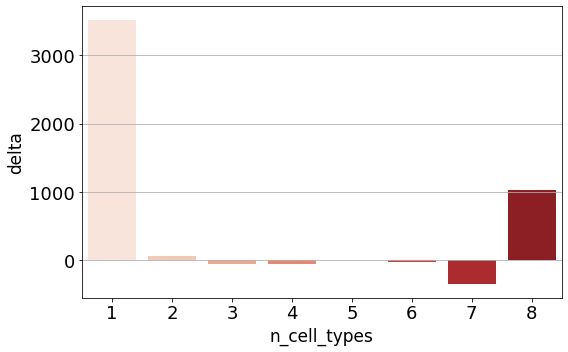

In [138]:
fig, axes = plt.subplots(1,1, figsize=(8, 5), tight_layout=True)
sns.barplot(data=deltas.to_frame().reset_index().rename(columns={'index': 'n_cell_types', 'n_cell_types': 'delta'}), x='n_cell_types', y='delta', palette=palette, 
           order=range(1,9))
plt.grid(axis='y')

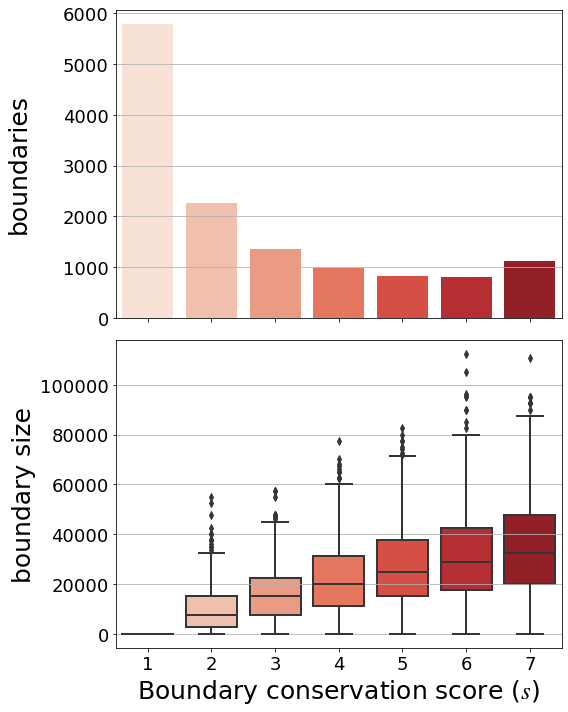

In [159]:
nrange = (1,8)

fig, axes = plt.subplots(2,1,sharex=True, figsize=(8, 10), tight_layout=True)
fontsize=25
palette="Reds"
sns.countplot(consensus_bounds.n_cell_types, ax=axes[0], order=range(*nrange), palette=palette)
axes[0].set_xlabel("")
axes[0].set_ylabel("boundaries\n", fontsize=fontsize)
axes[0].grid(axis='y')
sns.boxplot(data=consensus_bounds, x='n_cell_types', y="length", order=range(*nrange), ax=axes[1], palette=palette)
axes[1].set_xlabel("")
axes[1].set_ylabel("boundary size", fontsize=fontsize)
axes[1].grid(axis='y')
plt.xlabel("Boundary conservation score ($s$)", fontsize=fontsize)
fig.savefig(figure_path / "conserved_boundaries_stats.pdf", bbox_inches='tight', transparent=True)
plt.show()

# fig, axes = plt.subplots(3,1,sharex=True, figsize=(8, 13), tight_layout=True)
# fontsize=25
# palette="Reds"
# sns.countplot(consensus_bounds.n_cell_types, ax=axes[0], order=range(1,8), palette=palette)
# axes[0].set_xlabel("")
# axes[0].set_ylabel("# boundaries", fontsize=fontsize)
# sns.boxplot(data=consensus_bounds, x='n_cell_types', y="length", order=range(1,8), ax=axes[1], palette=palette)
# axes[1].set_xlabel("")
# axes[1].set_ylabel("boundary size (bp)", fontsize=fontsize)
# sns.barplot(data=consensus_bounds, x='n_cell_types', y="covered_genome", order=range(1,8), ax=axes[2], estimator=sum, ci=False, palette=palette)
# axes[2].set_ylabel("% covered genome (%bp)", fontsize=fontsize)
# plt.xlabel("Boundary conservation score ($s$)", fontsize=fontsize)
# fig.savefig(figure_path / "conserved_boundaries_stats.pdf", bbox_inches='tight', transparent=True)
# plt.show()

### Clustering consensus boundaries

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/seaborn/matrix.py:701: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/seaborn/matrix.py:701: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/seaborn/matrix.py:318: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())


<Figure size 518.4x320.4 with 0 Axes>

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


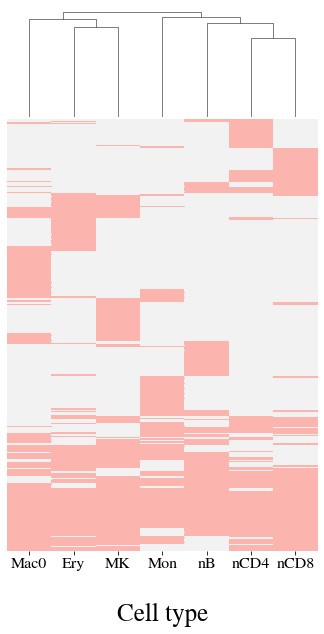

In [12]:
fig = plt.figure()
ax = sns.clustermap(data=consensus_bounds[sorted(all_boundary_positions.cell_type.unique())] > 0, 
                    yticklabels=False, figsize=(7, 10), cmap='Pastel1_r')
ax.ax_row_dendrogram.set_visible(False)
ax.cax.set_visible(False)
ax.ax_heatmap.set_xlabel("\nCell type", fontsize=fontsize)
fig.savefig(figure_path / "conserved_bounadries_clustering.pdf", bbox_inches='tight', transparent=True)
plt.show()

### Cell types lineages

In [13]:
def __get_category(x):
    cats =[]
    if x.lymphoid > 0:
        cats.append("lymphoid")
    if x.myeloid > 0:
        cats.append("myeloid")
    if x.blood > 0: 
        cats.append("blood")
    if len(cats) == 0:
        return "None"
    return "-".join(cats)

consensus_bounds['cell_type_category'] = pd.DataFrame({
    'lymphoid': consensus_bounds['nCD4'] + consensus_bounds['nCD8'] + consensus_bounds['nB'],
    'myeloid': consensus_bounds['Mon'] + consensus_bounds['Mac0'],
    'blood': consensus_bounds['Ery'] + consensus_bounds['MK']
}).apply(__get_category, axis=1)

In [14]:
tsne = TSNE(n_components=2)
tsne_comps = tsne.fit_transform(consensus_bounds[sorted(all_boundary_positions.cell_type.unique())])

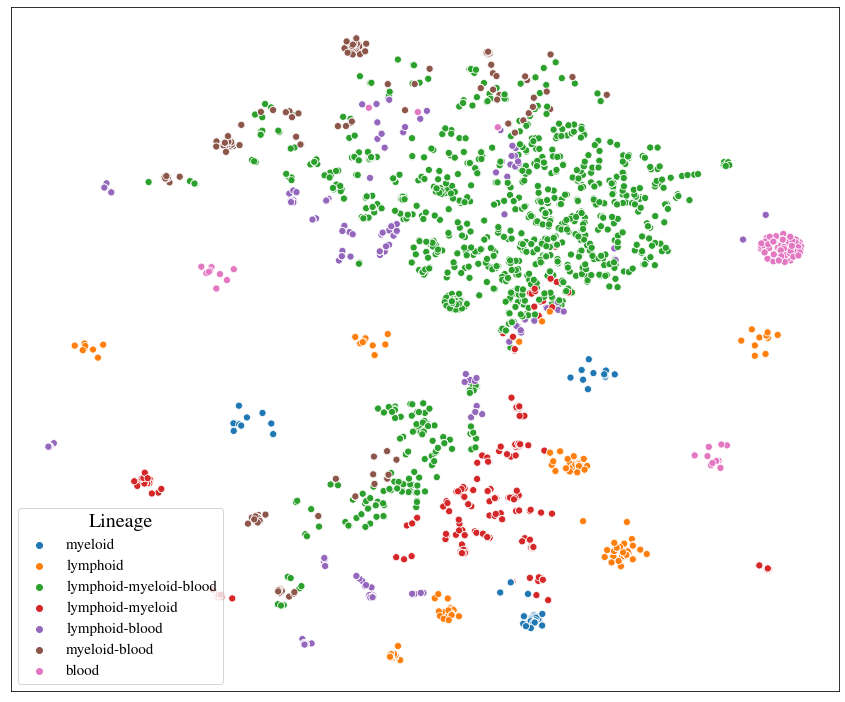

In [15]:
fig = plt.figure(figsize=(12,10))
ax = sns.scatterplot(x=tsne_comps[:, 0], y=tsne_comps[:, 1], hue=consensus_bounds.cell_type_category.tolist(), s=50)
ax.set_xticks([])
ax.set_yticks([])
plt.legend(title='Lineage', title_fontsize=20, fontsize='15')
fig.savefig(figure_path / "conserved_bounadries_TSNE_lineage.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Consensus boundaries

In [164]:
os.makedirs(src.interim_data_path / "consensus_boundaries", exist_ok=True)

In [165]:
for w in src.progress(all_boundary_positions_with_clusters.columns[8:]):
    consensus_bounds_w = get_consensus_regions(all_boundary_positions.assign(cluster=all_boundary_positions_with_clusters[w]))
    consensus_bounds_w['length'] = consensus_bounds_w.apply(lambda x: x.end - x.start + 1, axis=1)
    consensus_bounds_w['covered_genome'] = consensus_bounds_w.length / hg19_total_length
    consensus_bounds_w.to_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(w), sep="\t", index=False, header=True)

In [167]:
def to_UCSC(consensus_bounds_w, path):
    consensus_bounds_w[src.coords + ['n_cell_types']].to_csv(path, sep='\t', index=False, header=False)

In [170]:
consensus_bounds = pd.read_csv(src.interim_data_path / 'consensus_boundaries' / 'consensus_boundaries_w{}.tsv'.format(window), sep='\t')
print(window)
to_UCSC(consensus_bounds, src.interim_data_path / 'consensus_boundaries_w{}.bed'.format(window))
consensus_bounds.head()

25000


,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,1,1,0,0,5001,1.612296e-06
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,0,2,0,1,7501,2.418282e-06


## Consensus TADs

In [30]:
minimum_conservation = 1
window = 25000
consensus_bounds = get_consensus_regions(all_boundary_positions.assign(cluster=all_boundary_positions_with_clusters[window]))
sel_bounds = consensus_bounds[consensus_bounds.n_cell_types >= minimum_conservation]

In [31]:
gaps = pd.read_csv(src.external_data_path / "hg19_gaps.txt", sep='\t')
gaps.columns = src.coords + ['gap_type']
gaps = gaps.sort_values(src.coords).reset_index(drop=True)
gaps.head()

,chr,start,end,gap_type
0,chr1,0,10000,telomere
1,chr1,121535434,124535434,centromere
2,chr1,249240621,249250621,telomere
3,chr10,0,10000,telomere
4,chr10,39254935,42254935,centromere


In [32]:
def get_consensus_tads(sel_bounds):
    consensus_tads = BedTool.from_dataframe(sel_bounds[src.coords])\
                            .complement(genome='hg19')\
                            .subtract(BedTool.from_dataframe(gaps))\
                            .to_dataframe(names=src.coords)
    return consensus_tads

In [34]:
os.makedirs(src.interim_data_path / "consensus_tads", exist_ok=True)

In [35]:
consensus_tads = get_consensus_tads(sel_bounds)
consensus_tads.to_csv(src.interim_data_path / "consensus_tads" / "consensus_tads_w{}_min{}.tsv".format(window, minimum_conservation), sep="\t", index=False, header=True)

In [36]:
for w in src.progress(window_swap):
    for mc in range(1, 8):
        consensus_bounds = get_consensus_regions(all_boundary_positions.assign(cluster=all_boundary_positions_with_clusters[w]))
        sel_bounds = consensus_bounds[consensus_bounds.n_cell_types >= mc]
        consensus_tads = get_consensus_tads(sel_bounds)
        consensus_tads.to_csv(src.interim_data_path / "consensus_tads" / "consensus_tads_w{}_min{}.tsv".format(w, mc), sep="\t", index=False, header=True)